## detect the fake profiles in online social networks using Neural Network

In [1]:
import sys
import csv
import os
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import sexmachine.detector as gender
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc ,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,random_split

###### function for reading dataset from csv files

In [2]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("data/users.csv")
    fake_users = pd.read_csv("data/fusers.csv")
    # print genuine_users.columns
    # print genuine_users.describe()
    #print fake_users.describe()
    x=pd.concat([genuine_users,fake_users])   
    y=len(fake_users)*[0] + len(genuine_users)*[1]
    return x,y
    

###### function for predicting sex using name of person

In [3]:
def predict_sex(name_series):
    sex_predictor = gender.Detector(case_sensitive=False)
    # Handle cases where name is empty or malformed
    def get_gender_safe(x):
        try:
            return sex_predictor.get_gender(x.split()[0])
        except IndexError:
            return 'unknown'  # or handle as per your requirement

    first_name = name_series.str.split(' ').str.get(0)
    sex = first_name.apply(get_gender_safe)
    return sex

###### function for feature engineering

In [4]:
def extract_features(x):
    lang_list = x['lang'].unique()
    lang_dict = {name: i for i, name in enumerate(lang_list)}
    x.loc[:, 'lang_code'] = x['lang'].map(lambda x: lang_dict[x]).astype(int)
    x.loc[:, 'sex_code'] = predict_sex(x['name'])
    
    feature_columns_to_use = ['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count', 'sex_code', 'lang_code']
    x = x.loc[:, feature_columns_to_use]
    
    return x

###### function for plotting confusion matrix

In [5]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###### function for plotting ROC curve

In [6]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print("False Positive rate: ",false_positive_rate)
    print("True Positive rate: ",true_positive_rate)
    

    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

###### Function for training data using Neural Network

In [7]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def preprocess_data(X, y):
    # Select only numerical columns
    numerical_columns = X.select_dtypes(include=[np.number]).columns
    X_numerical = X[numerical_columns]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numerical)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)  # Convert list `y` to tensor

    return X_tensor, y_tensor

def train(X, y, epochs=100, batch_size=32, learning_rate=0.01, momentum=0.9, weight_decay=0.01):
    """ Trains and predicts dataset with a Neural Network classifier using PyTorch """

    # Preprocess data
    X_tensor, y_tensor = preprocess_data(X, y)

    # Split data into training and testing sets
    dataset = TensorDataset(X_tensor, y_tensor)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define model, optimizer, and criterion
    input_size = X_tensor.shape[1]
    hidden_size = 5
    output_size = len(np.unique(y))  # Number of classes

    model = SimpleNN(input_size, hidden_size, output_size)

    # Remove existing model file to avoid shape mismatch
    if os.path.isfile('model.pth'):
        os.remove('model.pth')

    # Load existing model if available
    if os.path.isfile('model.pth'):
        model.load_state_dict(torch.load('model.pth'))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    torch.save(model.state_dict(), 'model.pth')

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    return all_labels, all_preds

In [8]:
def percent_error(y_pred, y_true):
    if len(y_pred) != len(y_true):
        raise ValueError("Lengths of y_pred and y_true must be the same.")
    
    error_count = sum(1 for pred, true in zip(y_pred, y_true) if pred != true)
    percent_error = (error_count / len(y_true)) * 100.0
    
    return percent_error


In [9]:
import gender_guesser.detector as gender

In [10]:
print("reading datasets.....\n")
x,y=read_datasets()
x.describe()

reading datasets.....



,id,statuses_count,followers_count,friends_count,favourites_count,listed_count,default_profile,default_profile_image,geo_enabled,profile_use_background_image,profile_background_tile,utc_offset,protected,verified
count,2.818000e+03,2818.000000,2818.000000,2818.000000,2818.000000,2818.000000,1728.0,8.0,721.0,2760.0,489.0,1069.000000,0.0,0.0
mean,5.374889e+08,1672.198368,371.105039,395.363023,234.541164,2.818666,1.0,1.0,1.0,1.0,1.0,1478.391020,NaN,NaN
std,2.977005e+08,4884.669157,8022.631339,465.694322,1445.847248,23.480430,0.0,0.0,0.0,0.0,0.0,8108.211889,NaN,NaN
min,3.610511e+06,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-39600.000000,NaN,NaN
25%,3.620867e+08,35.000000,17.000000,168.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
50%,6.162253e+08,77.000000,26.000000,306.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
75%,6.177673e+08,1087.750000,111.000000,519.000000,37.000000,1.000000,1.0,1.0,1.0,1.0,1.0,3600.000000,NaN,NaN
max,1.391998e+09,79876.000000,408372.000000,12773.000000,44349.000000,744.000000,1.0,1.0,1.0,1.0,1.0,36000.000000,NaN,NaN


In [11]:
print("extracting featues.....\n")
x=extract_features(x)
print(x.columns)
print(x.describe())

extracting featues.....

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count    lang_code  
count   2818.000000  2818.000000  
mean       2.818666     0.556423  
std       23.480430     0.562567  
min    

In [12]:
print("training datasets.......\n")
y_test,y_pred =train(x,y)

training datasets.......



In [13]:
print('Classification Accuracy on Test dataset: ' ,accuracy_score(y_test, y_pred))

Classification Accuracy on Test dataset:  0.8953900709219859


In [14]:
print('Percent Error on Test dataset: ' ,percent_error(y_pred,y_test))

Percent Error on Test dataset:  10.460992907801419


Confusion matrix, without normalization
[[252  26]
 [ 33 253]]


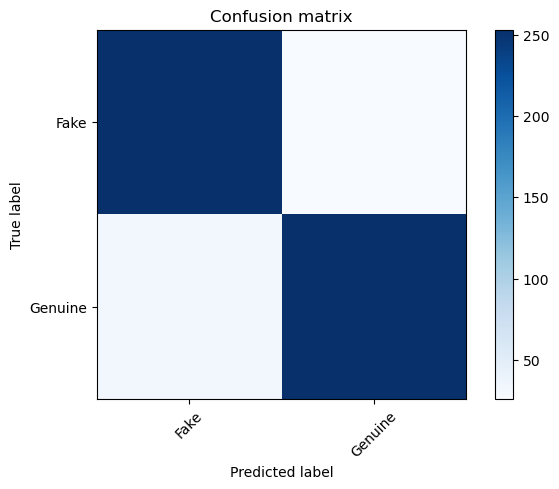

In [15]:
cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm)

Normalized confusion matrix
[[0.90647482 0.09352518]
 [0.11538462 0.88461538]]


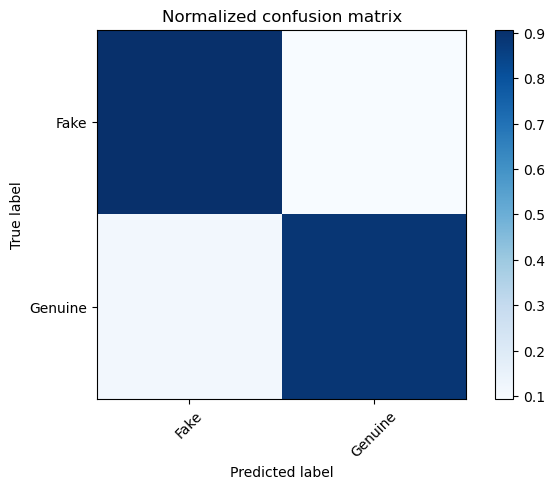

In [16]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [17]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.88      0.91      0.90       278
     Genuine       0.91      0.88      0.90       286

    accuracy                           0.90       564
   macro avg       0.90      0.90      0.90       564
weighted avg       0.90      0.90      0.90       564



In [18]:
s=roc_auc_score(y_test, y_pred)
print ("roc_auc_score : ",s)

roc_auc_score :  0.8955451023796347


False Positive rate:  [0.         0.09352518 1.        ]
True Positive rate:  [0.         0.88461538 1.        ]


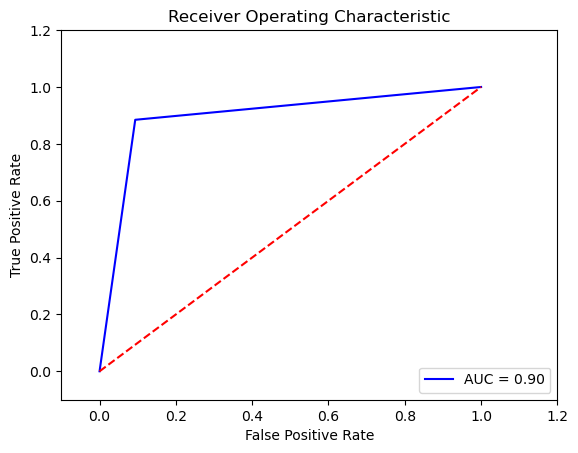

In [19]:
 plot_roc_curve(y_test, y_pred)